# LAB ASSIGNMENT 10 OF IMAGE SIGNAL PROGRESSING

---

## NON - LOCAL MEANS FILTERING

---

### MANSI KAKKAR

### EE21S063

## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

## Reading Images

In [47]:
krishna_1 = io.imread('krishna_0_001.png')/255 #noisy Image
krishna = io.imread('krishna.png')/255 #Latent Image

## Displaying Images

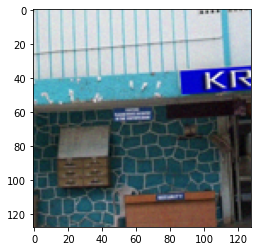

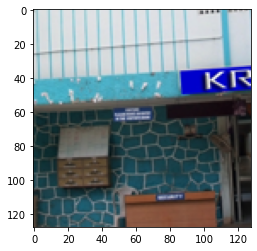

In [9]:
plt.imshow(krishna_1)
plt.show()
plt.imshow(krishna)
plt.show()

## Zero Padded Image

In [37]:
def padding_image(image, padding_size):
    #2d padding
    x,y = np.shape(image)
    padded = np.zeros(((x+padding_size*2),(y+padding_size*2)))
    padded[padding_size:-padding_size, padding_size:-padding_size] = image
    return padded

## Zero padding RGB Image

In [14]:
def zero_padding_RGB(image, W, Wsim):
    #3d padding
    x, y, _ = np.shape(image)
    padding_size = W + Wsim 
    padded = np.zeros((x+padding_size*2, y+padding_size*2, 3))
    for i in range(3):
        padded[padding_size:-padding_size, padding_size:-padding_size, i] = image[:, :, i]
    return padded

## PSNR

In [ ]:
def psnr(latent_image, noisy_image):
    mse = np.mean((noisy_image - latent_image)**2)
    if mse>0:
        return 20*np.log10(np.max(latent_image)/np.sqrt(mse))
    else:
        return np.float128(np.inf)     

## Non Local Means Filtering (NLM) 

Perform non-local means on an RGB image for given values of NLM search neighbourhood radius $W$, the similarity neighbourhood radius $W_{sim}$, and the filter parameter $\sigma_{NLM}$.



In [57]:
def NLM(image, W, Wsim, sigma):
    x, y, _ = np.shape(image)
    padded = zero_padding_RGB(image, W, Wsim)
    d = W + Wsim
    final_image = np.zeros((x, y, 3))
    for i in range(3):
        padded_img = padded[:, :, i]
        for j in range(d, x+d):
            for k in range(d, y+d):
                patch = padded_img[j-Wsim:j+Wsim+1, k-Wsim: k+Wsim+1]
                neighbourhood = padded_img[j-d:j+d+1, k-d:k+d+1]
                final_image[j-d, k-d, i] = NLM_Local(patch, neighbourhood, d, Wsim, sigma)
    return final_image

**NLM Local**


Given an image patch of size $(2W_{sim}+1)\times (2W_{sim}+1)$ around a pixel $p$, calculate the filtered image intensity at $p, g(p)$. 

$$
g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})f(q)
$$

$G_{p}$ is a neighborhood of size $(2W+1)\times (2W+1)$ around $p$, $G_{\sigma}$ is the Gaussian intensity weight for a given $\sigma$ as defined in the previous section, and, $f(q)$ is the image intensity at pixel $q$. $Z_{p}$ is a normalizing constant given by

$$
Z_{p} = \Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})
$$

This ensures that we do not brighten or darken the image while filtering.


In this function only we have defined gaussian $G_{p}$ so no need to specially write a function for that.

$$
w_{pq} \propto exp\left[{\frac{\|\mathcal{N}_{p}-\mathcal{N}_{q}\|^{2}_{F}}{2\sigma^{2}}}\right]
$$


In [116]:
def NLM_Local(p, neighbourhood, d, Wsim, sigma,return_kernel = False):
    weights = np.zeros((2*d+1 - 2*Wsim, 2*d+1 - 2*Wsim))
    val = 0
    for i in range(Wsim, 2*d+1 - Wsim):
        for j in range(Wsim, 2*d+1 - Wsim):
            q = neighbourhood[i-Wsim:i+Wsim+1, j-Wsim:j+Wsim+1]
            if sigma > 0:
                weights[i-Wsim, j-Wsim] = np.exp(np.sum((-1*(p-q)**2)/(2*sigma**2)))
            else:
                if np.sum(np.abs(p-q)) == 0:
                    weights[i-Wsim, j-Wsim] = 1
                else:
                    weights[i-Wsim, j-Wsim] = 0
            val += weights[i-Wsim, j-Wsim]*neighbourhood[i, j]
    if return_kernel:
        return val/np.sum(weights), weights/np.sum(weights)
    else:
        return val/np.sum(weights)

## 2D Convolution Function

In [67]:
# 2D Convolution
def Convolution_2d(image, kernel):
    #get shape of image
    [x,y] = np.shape(image)
    #get kernel size
    w_size = len(kernel)
    d = w_size//2
    #if kernel is single value, simply multiply and return
    if d==0:
        filtered_image = kernel*image
    else:
        padded_image = padding_image(image, d)
        filtered_image = np.zeros((x, y))
        for i in range(d, x+d):
            for j in range(d, x+d):
                # extract image patch
                patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                # multiply image patch with the kernel, sum and store
                filtered_image[i-d, j-d] = np.sum(patch*kernel)
    return filtered_image
    

## Gaussian Kernel Function


Constructing the Gaussian Kernel with Normal Distibution formula given standard deviation &\sigma$ . 

---

The Gaussian Kernel is defined as : 

$G(i,j) = \frac{1}{2\pi\sigma^2} \exp^{\frac{-x^2 - y^2}{2 \sigma^2}}$

---

We have nomalised it as the entries of G might not sum upto 1, such that

$G(i,j) = \frac{1}{2\pi\sigma^2 S} \exp^{\frac{-x^2 - y^2}{2 \sigma^2}}$

---

Since, we have done this in class as well that the kernel's values must sum upto 1 otherwise if would experience variations in the image


In [61]:
#Defining Gaussian Kernel
def gaussian_kernel(size,sigma):
    
    #creating blank kernel
    kernel = np.zeros((size, size))
    #absolute half of the size
    s_c = size//2
    
    #for condition where sigma is 0
    if size==1:
        kernel = np.ones((size, size))
        return kernel
    
    #defining kernel
    for x in range(size):
        for y in range(size):
            temp = np.exp((-((x-s_c)**2)-((y-s_c)**2))/(2*(sigma**2)))
            kernel[x,y] = temp / (2*np.pi*(sigma**2))
            
    #dividing by th sum of kernel
    kernel = kernel/np.sum(kernel)
    return kernel

## Gaussian Denoising Function

For an RGB image, filter each channel independently.

Filter an RGB image for a given $\sigma$ and $w$

In [65]:
def gaussian_denoising_RGB(image, sigma, size):
    x, y, _ = np.shape(image)
    kernel = gaussian_kernel(size, sigma)
    filtered_image = np.zeros((x, y, 3))
    for i in range(3):
        filtered_image[:, :, i] = Convolution_2d(image[:, :, i], kernel)
    return filtered_image

# RESULTS

In [71]:
#Initialising as per the problem statement
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
Wsim = 3
W_values = [3, 5]
gaussian_window_size = 7
rows = (31, 38)
columns = (46, 58)
NLM_data = {}
Gaussian_data = {}

#Gaussian Denoising for Noisy image
for sigma in sigma_values:
    print(f"Performing Gaussian filtering for sigma={sigma}")
    gaussian_filtered_image = gaussian_denoising_RGB(krishna_1, sigma, gaussian_window_size)
    #Storing PSNR along with gaussian filtered image 
    Gaussian_data[sigma] = (gaussian_filtered_image,psnr(krishna, gaussian_filtered_image))

# NLM Filtering for Noisy image
for sigma in sigma_values:
    for W in W_values:
        print(f"Performing NLM filtering for sigma={sigma}, W={W}, W_sim={Wsim}")
        NLM_filtered_image = NLM(krishna_1, W, Wsim, sigma)
        #Storing PSNR along with NLM filtered image 
        NLM_data[(sigma, W)] = (NLM_filtered_image,psnr(krishna, NLM_filtered_image))

Performing Gaussian filtering for sigma=0.1
Performing Gaussian filtering for sigma=0.2
Performing Gaussian filtering for sigma=0.3
Performing Gaussian filtering for sigma=0.4
Performing Gaussian filtering for sigma=0.5
Performing NLM filtering for sigma=0.1, W=3, W_sim=3
Performing NLM filtering for sigma=0.1, W=5, W_sim=3
Performing NLM filtering for sigma=0.2, W=3, W_sim=3
Performing NLM filtering for sigma=0.2, W=5, W_sim=3
Performing NLM filtering for sigma=0.3, W=3, W_sim=3
Performing NLM filtering for sigma=0.3, W=5, W_sim=3
Performing NLM filtering for sigma=0.4, W=3, W_sim=3
Performing NLM filtering for sigma=0.4, W=5, W_sim=3
Performing NLM filtering for sigma=0.5, W=3, W_sim=3
Performing NLM filtering for sigma=0.5, W=5, W_sim=3


## NLM Filtering
Display the noisy image and results of NML filtering for different values of $\sigma_{NLM}$ and $W$. $W_{sim}$ is taken to be $3$ for all of the cases.

Here, both for $W=3$ and $W=5$ are displayed

Text(0.5, 1.0, 'NLM filtered image for sigma =0.5 and W = 5')

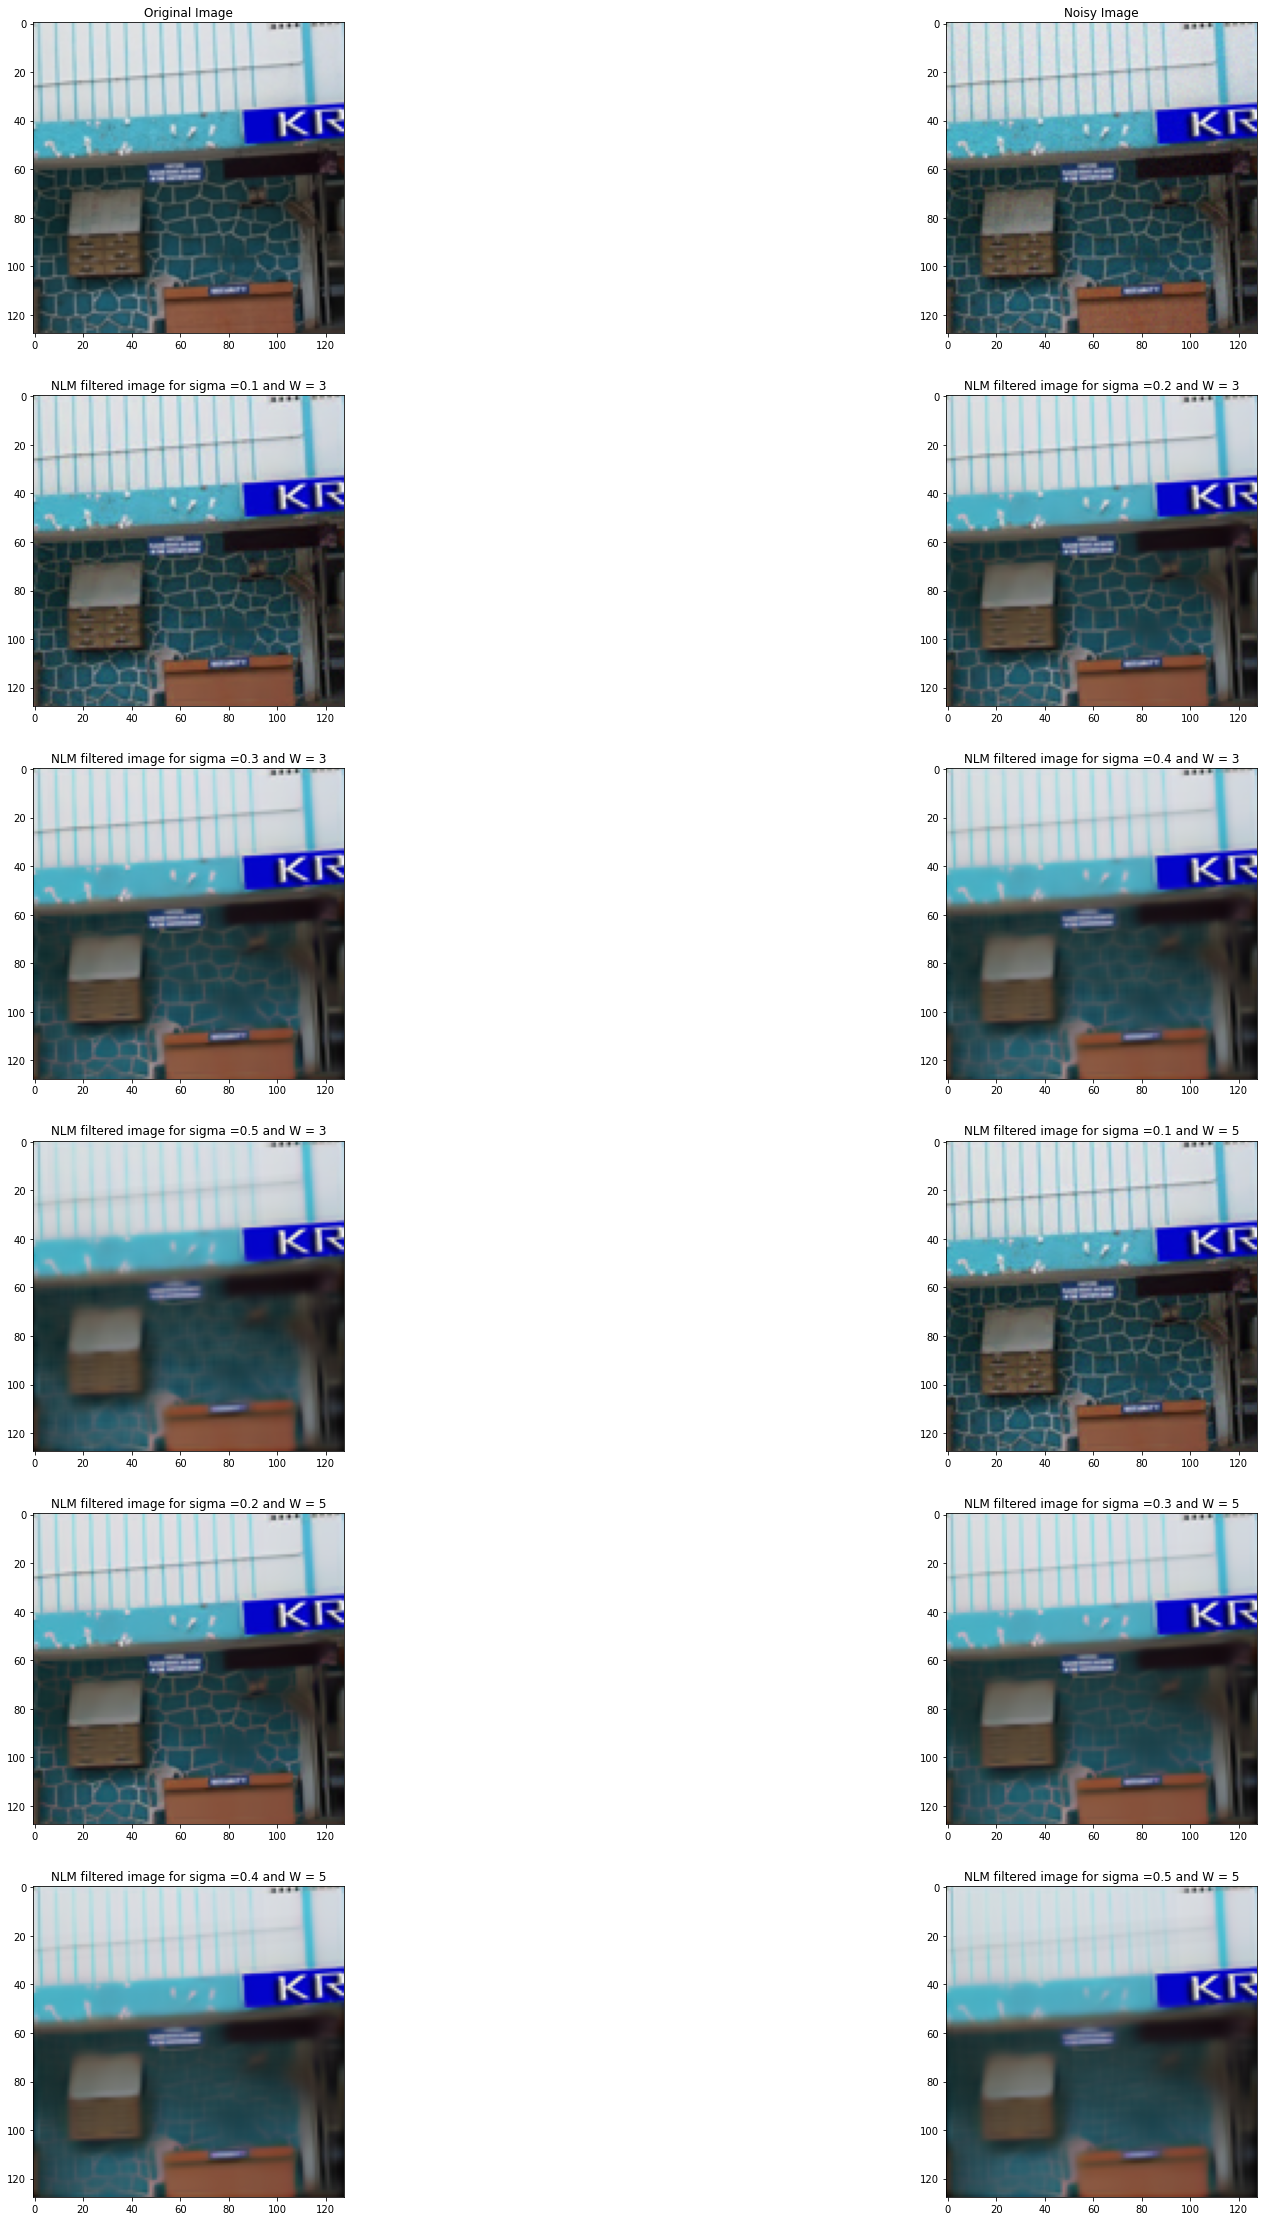

In [86]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7, ax8),(ax9, ax10),(ax11, ax12)) = plt.subplots(6, 2, figsize = (30,40))
ax1.imshow(krishna)
ax1.set_title('Original Image')
ax2.imshow(krishna_1)
ax2.set_title('Noisy Image')
ax3.imshow(NLM_data[sigma_values[0], W_values[0]][0])
ax3.set_title(f"NLM filtered image for sigma ={sigma_values[0]} and W = {W_values[0]}")
ax4.imshow(NLM_data[sigma_values[1], W_values[0]][0])
ax4.set_title(f"NLM filtered image for sigma ={sigma_values[1]} and W = {W_values[0]}")
ax5.imshow(NLM_data[sigma_values[2], W_values[0]][0])
ax5.set_title(f"NLM filtered image for sigma ={sigma_values[2]} and W = {W_values[0]}")
ax6.imshow(NLM_data[sigma_values[3], W_values[0]][0])
ax6.set_title(f"NLM filtered image for sigma ={sigma_values[3]} and W = {W_values[0]}")
ax7.imshow(NLM_data[sigma_values[4], W_values[0]][0])
ax7.set_title(f"NLM filtered image for sigma ={sigma_values[4]} and W = {W_values[0]}")
ax8.imshow(NLM_data[sigma_values[0], W_values[0]][0])
ax8.set_title(f"NLM filtered image for sigma ={sigma_values[0]} and W = {W_values[1]}")
ax9.imshow(NLM_data[sigma_values[1], W_values[1]][0])
ax9.set_title(f"NLM filtered image for sigma ={sigma_values[1]} and W = {W_values[1]}")
ax10.imshow(NLM_data[sigma_values[2], W_values[1]][0])
ax10.set_title(f"NLM filtered image for sigma ={sigma_values[2]} and W = {W_values[1]}")
ax11.imshow(NLM_data[sigma_values[3], W_values[1]][0])
ax11.set_title(f"NLM filtered image for sigma ={sigma_values[3]} and W = {W_values[1]}")
ax12.imshow(NLM_data[sigma_values[4], W_values[1]][0])
ax12.set_title(f"NLM filtered image for sigma ={sigma_values[4]} and W = {W_values[1]}")


## Gaussian Filtering
Display the noisy image and results of NML filtering for different values of $\sigma$. The window size is held constant at $7\times 7$

Text(0.5, 1.0, 'Gaussian filtering with sigma = 0.5')

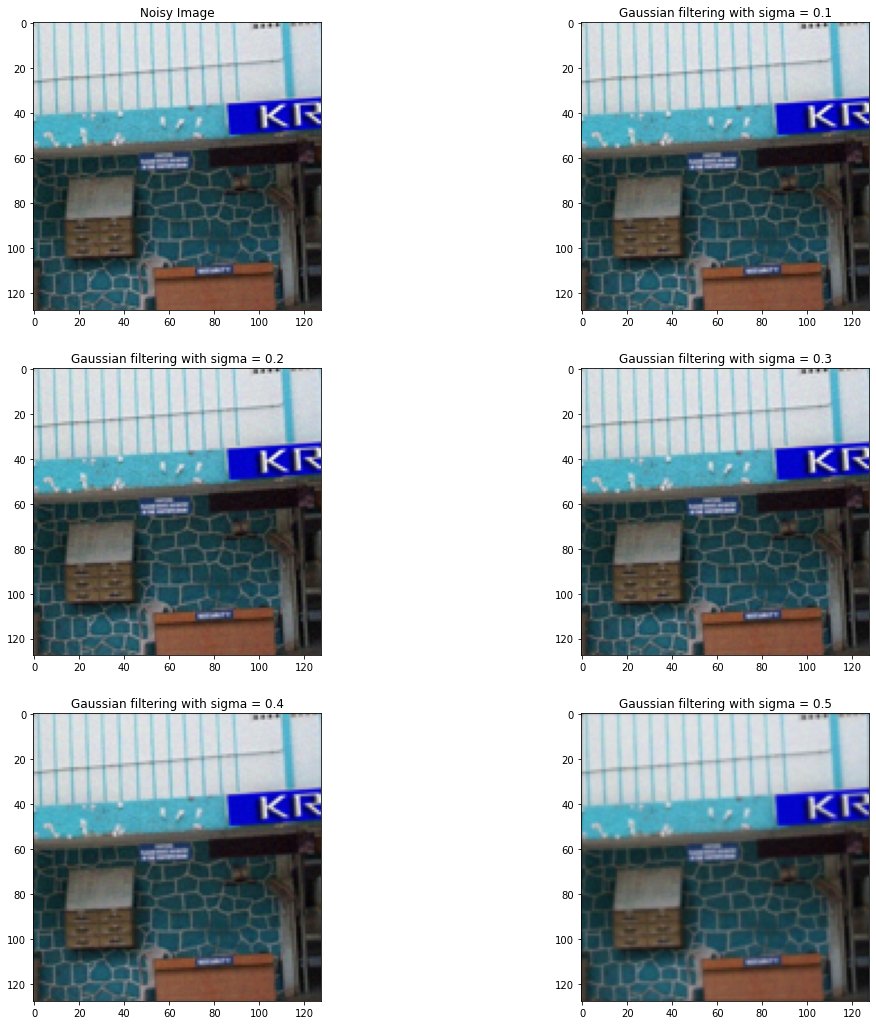

In [90]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (18,18))
ax1.imshow(krishna_1)
ax1.set_title('Noisy Image')
ax2.imshow(Gaussian_data[sigma_values[0]][0])
ax2.set_title(f"Gaussian filtering with sigma = {sigma_values[0]}")
ax3.imshow(Gaussian_data[sigma_values[1]][0])
ax3.set_title(f"Gaussian filtering with sigma = {sigma_values[1]}")
ax4.imshow(Gaussian_data[sigma_values[2]][0])
ax4.set_title(f"Gaussian filtering with sigma = {sigma_values[2]}")
ax5.imshow(Gaussian_data[sigma_values[3]][0])
ax5.set_title(f"Gaussian filtering with sigma = {sigma_values[3]}")
ax6.imshow(Gaussian_data[sigma_values[4]][0])
ax6.set_title(f"Gaussian filtering with sigma = {sigma_values[4]}")


## PSNR Display

Showing comparison of PSNRs of different filters comparative to the baseline.

Basically, showing the performance.

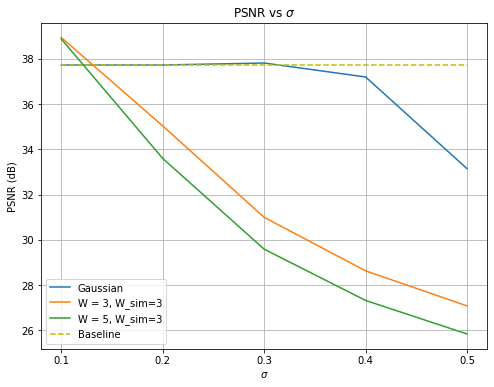

In [95]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_values, [Gaussian_data[sigma][1] for sigma in sigma_values])
plt.plot(sigma_values, [NLM_data[(sigma, W_values[0])][1] for sigma in sigma_values])
plt.plot(sigma_values, [NLM_data[(sigma, W_values[1])][1] for sigma in sigma_values])
plt.plot(sigma_values, [psnr(krishna, krishna_1) for sigma in sigma_values], 'y--')
plt.xlabel(r"${\sigma}$")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend(["Gaussian", "W = 3, W_sim=3", "W = 5, W_sim=3", "Baseline"])
plt.xticks(sigma_values)
plt.title(r"PSNR vs $\sigma$")
plt.show()

## Gaussian Kernel Display

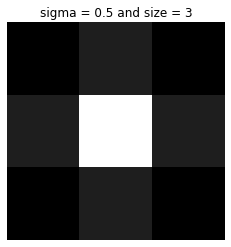

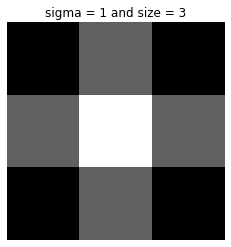

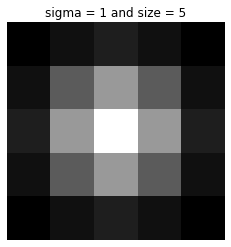

In [114]:
plt.imshow(gaussian_kernel(size = 3, sigma = 0.5), 'gray')
plt.title('sigma = 0.5 and size = 3')
plt.axis('off')
plt.show()
plt.imshow(gaussian_kernel(size = 3, sigma = 1), 'gray')
plt.title('sigma = 1 and size = 3')
plt.axis('off')
plt.show()
plt.imshow(gaussian_kernel(size = 5, sigma = 1), 'gray')
plt.title('sigma = 1 and size = 5')
plt.axis('off')
plt.show()

## Function to show Kernels 

Visualize the kernels used in Gaussian and NLM filtering. 

For Gaussian filtering, a $11\times 11$ kernel with $\sigma_{g}=1$ is used.

For NLM filtering, we use $\sigma_{NLM}=0.5, W=5, W_{sim}=3$. 

The resulting $11\times 11$ kernels are shows for the given locations.

In [157]:
def show_kernel(image, row1, column1, row2, column2, W = None, Wsim = None, sigma = None, is_kernel = False):
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
    if not is_kernel:
        ax1.imshow(image[row1-W-1:row1+W, column1-W-1:column1+W])
        ax1.title.set_text(f"row : {row1}, column : {column1}")
        ax2.imshow(image[row1-W-1:row1+W, column2-W-1:column2+W])
        ax2.title.set_text(f"row : {row1}, column : {column2}")
        ax3.imshow(image[row2-W-1:row2+W, column1-W-1:column1+W])
        ax3.title.set_text(f"row : {row2}, column : {column1}")
        ax4.imshow(image[row2-W-1:row2+W, column2-W-1:column2+W])
        ax4.title.set_text(f"row : {row2}, column : {column2}")
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        plt.show()
    else:
        padded_image = zero_padding_RGB(image, W, Wsim)
        d = W + Wsim
        k1 = np.zeros((2*W+1, 2*W+1, 3))
        k2 = np.zeros((2*W+1, 2*W+1, 3))
        k3 = np.zeros((2*W+1, 2*W+1, 3))
        k4 = np.zeros((2*W+1, 2*W+1, 3))
        for i in range(3):
            _, k1[:,:,i] = NLM_Local(image[row1-Wsim-1:row1+Wsim, column1-Wsim-1:column1+Wsim, i],
                        padded_image[row1-1:row1+2*d, column1-1:column1+2*d, i], d, Wsim, sigma, return_kernel=True)
            
            _, k2[:,:,i] = NLM_Local(image[row1-Wsim-1:row1+Wsim, column2-Wsim-1:column2+Wsim, i],
                        padded_image[row1-1:row1+2*d, column2-1:column2+2*d, i], d, Wsim, sigma, return_kernel=True)
           
            _, k3[:,:,i] = NLM_Local(image[row2-Wsim-1:row2+Wsim, column1-Wsim-1:column1+Wsim, i],
                        padded_image[row2-1:row2+2*d, column1-1:column1+2*d, i], d, Wsim, sigma, return_kernel=True)
            
            _, k4[:,:,i] = NLM_Local(image[row2-Wsim-1:row2+Wsim, column2-Wsim-1:column2+Wsim, i],
                        padded_image[row2-1:row2+2*d, column2-1:column2+2*d, i], d, Wsim, sigma, return_kernel=True)
           
        ax1.imshow(k1/np.max(k1))
        ax1.title.set_text(f"row : {row1}, column : {column1}")
        ax2.imshow(k2/np.max(k2))
        ax2.title.set_text(f"row : {row1}, column : {column2}")
        ax3.imshow(k3/np.max(k3))
        ax3.title.set_text(f"row : {row2}, column : {column1}")
        ax4.imshow(k4/np.max(k4))
        ax4.title.set_text(f"row : {row2}, column : {column2}")
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        plt.show()

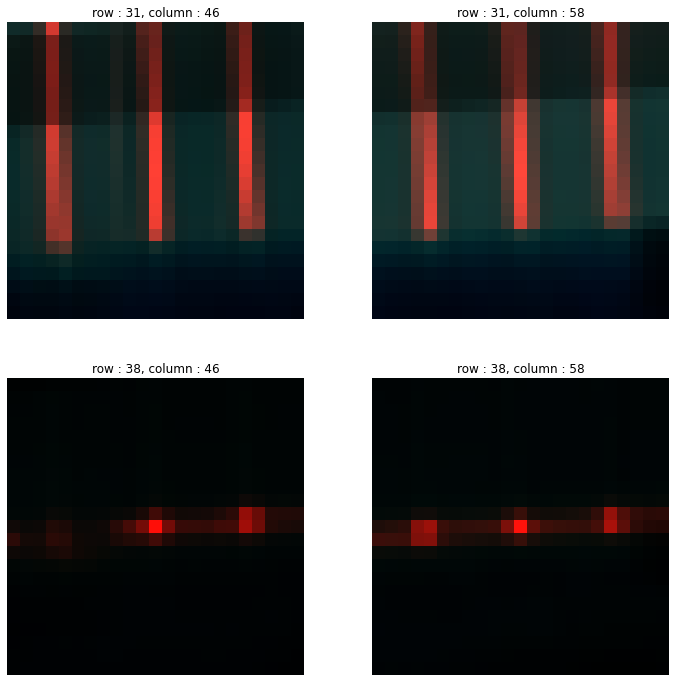

In [159]:
show_kernel(krishna, rows[0], columns[0], rows[1],columns[1], W=11, Wsim = 3, sigma = 0.5, is_kernel = True)

**For Latent Image**

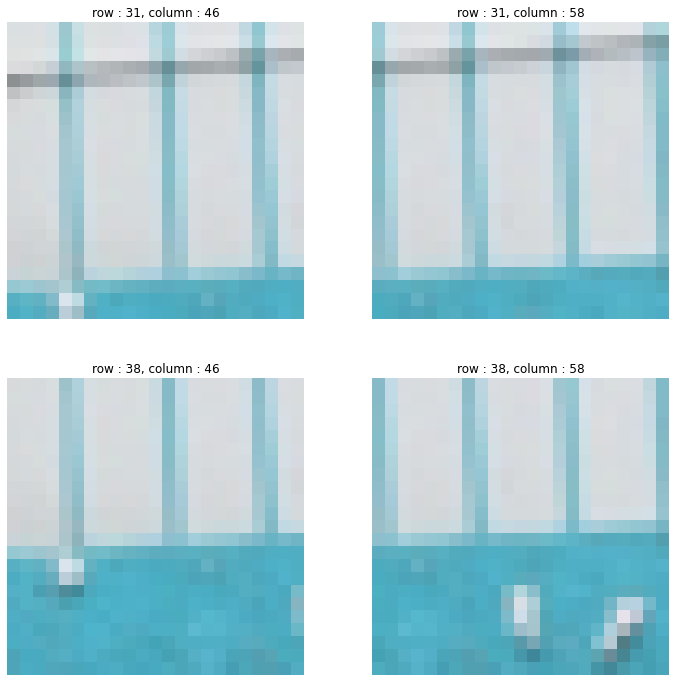

In [148]:
show_kernel(krishna, rows[0], columns[0], rows[1],columns[1], W=11)

**For Noisy Image**

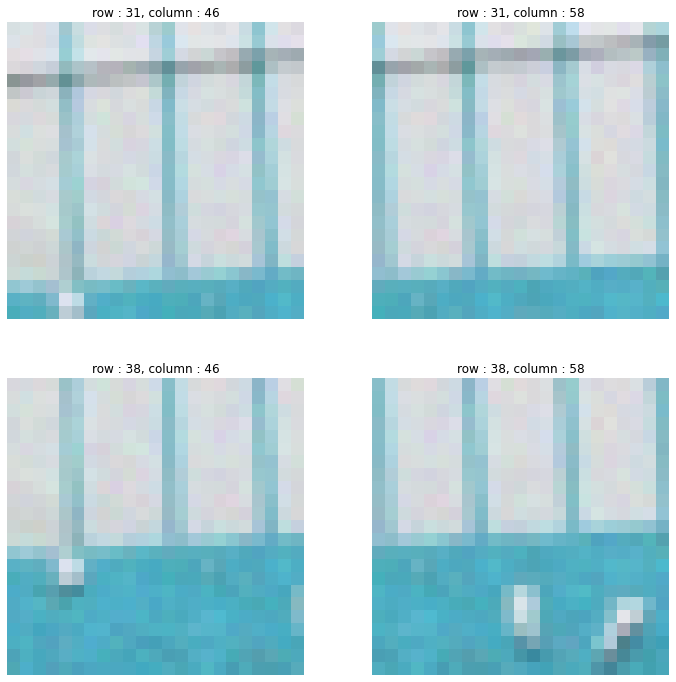

In [149]:
show_kernel(krishna_1, rows[0], columns[0], rows[1],columns[1], W=11)

**For NLM filter data for sigma = 0.4 and W = 3**

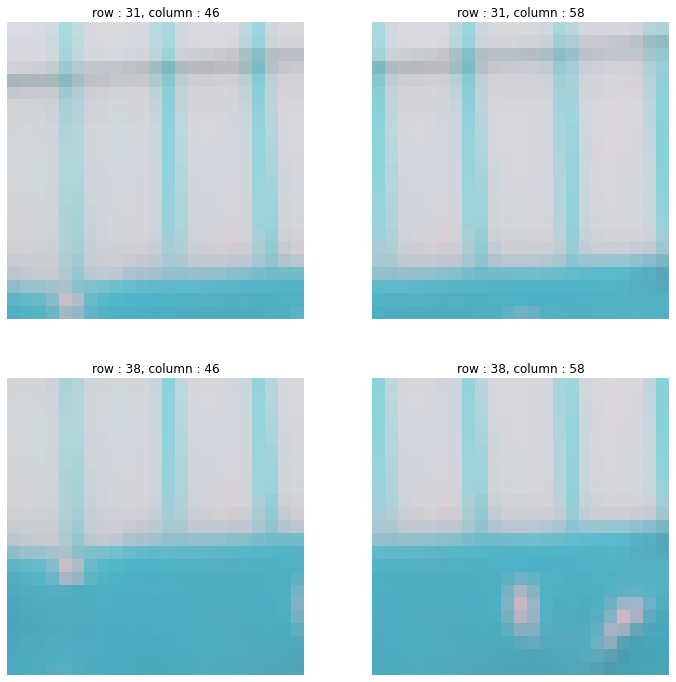

In [150]:
show_kernel(NLM_data[(sigma_values[3], W_values[0])][0], rows[0], columns[0], rows[1],columns[1], W=11)

**For NLM filter data for sigma = 0.4 and W = 5**

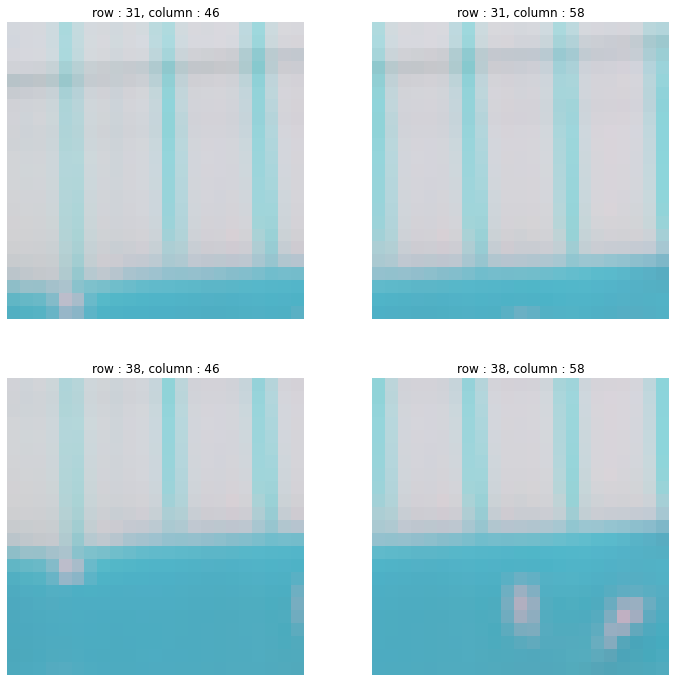

In [151]:
show_kernel(NLM_data[(sigma_values[3], W_values[1])][0], rows[0], columns[0], rows[1],columns[1], W=11)

**For Gaussian filter data for sigma = 0.4 and W = 5**

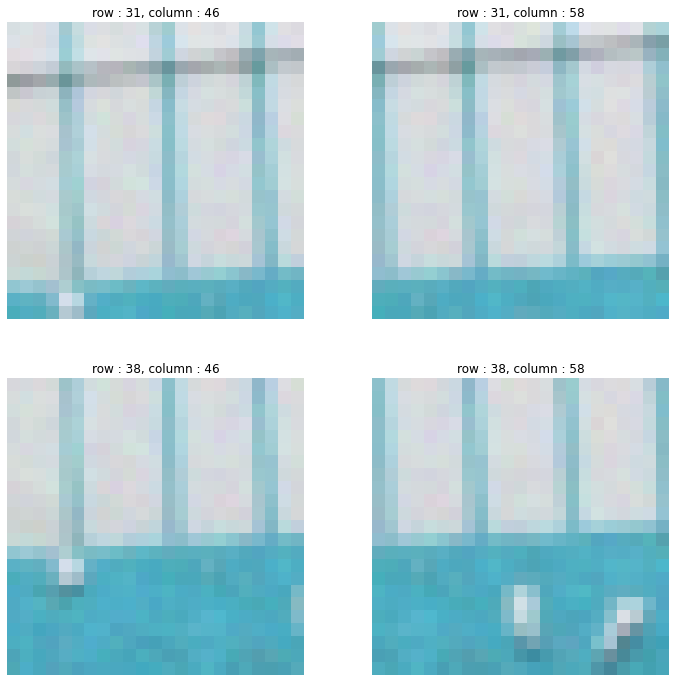

In [162]:
show_kernel(Gaussian_data[sigma_values[3]][0], rows[0], columns[0], rows[1],columns[1], W=11)

# Observations:

* Gaussian filter for small values of $\sigma$ makes almost no difference but as the value we can observe considerable difference. This can also be observed from PSNR graph where for small values of sigma, it comes close to baseline.


* For the case of NLM Filtering even the small values of $\sigma$ can also show considerable difference in the noise filtering. Small sigma value removes noise but preserves the edges


* We get better PSNR for NLM Filter for $\sigma_{NLM} = 0.1$ and $W_{sim} = 3$ beyond which if we increase $W$ or $\sigma_{NLM}$ it gets more smoothened


* As we increase the sigma value for NLM the image smoothens and edges deteriorate, hence higher values of sigma are not preferred


* The Gaussian kernel is space-invariant and the weight attributed to intensity at another pixel $q$ while calculating the filtered value at a pixel $p$ depends only on the Euclidean norm between $p$ and $q$


* NLM kernels on the other hand attach a lot of weight only to pixels whose neighborhood is similar to the neighborhood of the pixel under consideration


* NLM filtering is computationally expensive as compared to Gaussian filtering.

